# MIMO Least Squares Detection

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates:
* Toy example of MIMO Detection with constrained least-squares
* Implementation of constrained least squares via gradient descent

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

We want to transmit $x$ over a MIMO channel $H\in \mathbb{R}^{k \times n}$. 
The receiver measures $y$, which is the result of
$y=Hx$. At the receiver side, we have channel state information (CSI) and therefore know $H$. 

Specify the simulation paramters. 
You can vary k (# RX antennas) but leave n (# TX antennas) fixed 
if you want to get a graphical output.

In [2]:
n = 2 # Number of TX antennas. Leave n fixed to 2!
k = 3 # Number of RX antennas.You can play around with k.
x = np.random.rand(n) # Transmit data (random).
x = x/np.linalg.norm(x) * np.random.rand() # Normalize x to a transmit energy in [0,1].
H = np.random.randn(k, n) # MIMO channel (random).
y = np.dot(H, x) # Apply channel to data.
print("x =",x)

x = [0.02436777 0.07559526]


Now, we want to estimate $\boldsymbol{x}$ by using a **Least-Square Detector**:
$\min\limits_{\boldsymbol{x}} ||\boldsymbol{H}\boldsymbol{x}-\boldsymbol{y}||_2^2$.  
This is a minimization problem.

The first approach is a line search with **gradient descent** direction and fixed step length.

In [4]:
delta = 1e-9 # Threshold for stopping criterion.
epsilon = 1e-4 # Step length.
max_iter = 100000

# Initial guess.
init_xg = np.random.rand(*x.shape)*1.4
xg = init_xg

# Gradient descent line search.
points = []
while len(points) < max_iter:
    points.append(xg)
    grad = 2*H.T.dot(H).dot(xg)-2*np.dot(H.T,y) # Calc gradient at current position.
    if np.linalg.norm(grad) < delta:
        break
    xg = xg - 2*epsilon*grad
print("xg =",xg)

xg = [0.02436778 0.07559527]


Plots:  
 * [left subplot]: The function and the trajectory of the line search. 
 The minimum at $x$ is marked with a red cross and 
 the first guess with a green cross.
 * [right subplot]: The euclidean distance of the trajectory 
 to the minimum at each iteration.

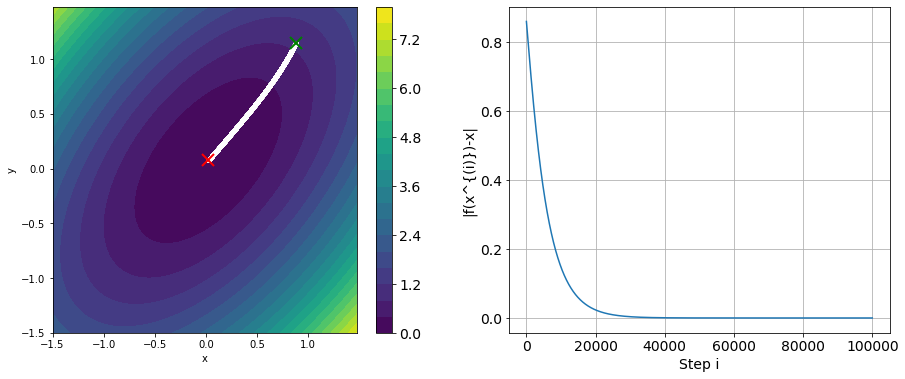

In [5]:
def obj_func(mesh):
    return np.linalg.norm(np.tensordot(H, mesh, axes=1)-y[:, np.newaxis, np.newaxis], axis=0)**2

# Least-Square function.doing a matrix multiplication for a mesh
x_grid = np.arange(-1.5, 1.5, 0.02)
y_grid = np.arange(-1.5, 1.5, 0.02)
X, Y = np.meshgrid(x_grid, y_grid)
fZ = obj_func([X, Y])

# Line search trajectory.
trajectory_x = [points[i][0] for i in range(len(points))]
trajectory_y = [points[i][1] for i in range(len(points))]

plt.figure(1,figsize=(15,6))
plt.subplot(121)
plt.rcParams.update({'font.size': 14})
plt.contourf(X,Y,fZ,levels=20)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.plot(trajectory_x, trajectory_y,marker='.',color='w',linewidth=2)
plt.plot(x[0], x[1], marker='x',color='r',markersize=12, markeredgewidth=2)
plt.plot(init_xg[0],init_xg[1], marker='x',color='g',markersize=12, markeredgewidth=2)
plt.subplot(122)
plt.plot(range(0,len(points)),np.abs(list(zip(*(points-x)))[0]))
plt.grid(True)
plt.xlabel("Step i")
plt.ylabel("|f(x^{(i)})-x|")
plt.show()


Now we use **Newton's method**. It reaches the minimum in one step, 
because the objective function is quadratic (Least-Square).

In [6]:
xh = np.linalg.inv(H.T.dot(H)).dot(H.T).dot(y)
print('xh = ', xh)


xh =  [0.02436777 0.07559526]


A limitation of the transmit signal energy is known.  
$\boldsymbol{x}^T\boldsymbol{x} \leq 1$.  
We add this information as a **constraint** to the problem with the use
of a **Lagrange multiplier**. 
Use gradient descent direction to find the optimal $\boldsymbol{x}$ of the new constrained
problem.


In [7]:
max_iter = 100000
lam = 5 # Init value for lambda.
init_xg = np.random.rand(*x.shape)*1.4 # Initial guess.
xg = init_xg

points = []
while len(points) < max_iter:
    points.append(xg)
    xg = np.linalg.inv(H.T.dot(H)+lam*np.identity(n)).dot(H.T).dot(y)
    lam = lam - epsilon*(1-xg.T.dot(xg))
    if np.abs(1-xg.T.dot(xg)) < delta or lam < delta:
        break
print(xg)

[0.02435899 0.07558292]


Plots:  
 * [left subplot]: The function and the trajectory of the line search. 
 The minimum at $x$ is marked with a red cross and 
 the first guess with a green cross. The constraint is displayed with a black line.
 * [right subplot]: The euclidean distance of the trajectory 
 to the minimum at each iteration.

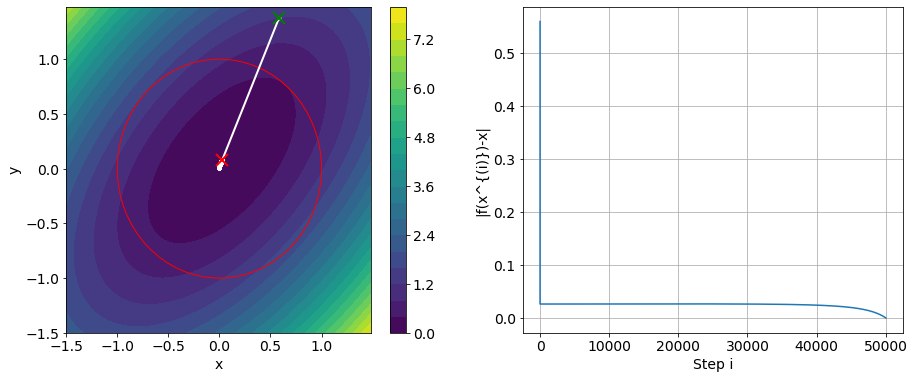

In [8]:
trajectory_x = [points[i][0] for i in range(len(points))]
trajectory_y = [points[i][1] for i in range(len(points))]

x_grid = np.arange(-1.5, 1.5, 0.02)
y_grid = np.arange(-1.5, 1.5, 0.02)
X, Y = np.meshgrid(x_grid, y_grid)
fZ = obj_func([X, Y])

plt.figure(1,figsize=(15,6))
plt.subplot(121)
fig = plt.gcf()
ax = fig.gca()
plt.rcParams.update({'font.size': 14})
plt.contourf(X,Y,fZ,levels=20)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
circle = plt.Circle((0,0),radius=1, fill=False, color='r')
ax.add_artist(circle)
plt.plot(trajectory_x, trajectory_y,marker='.',color='w',linewidth=2)
plt.plot(x[0],x[1], marker='x',color='r',markersize=12, markeredgewidth=2)
plt.plot(init_xg[0],init_xg[1], marker='x',color='g',markersize=12, markeredgewidth=2)
plt.subplot(122)
plt.plot(range(0,len(points)),np.abs(list(zip(*(points-x)))[0]))
plt.grid(True)
plt.xlabel("Step i")
plt.ylabel("|f(x^{(i)})-x|")
plt.show()
